In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten, Lambda
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, History
import nltk

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 960M (0000:02:00.0)


In [1]:
token = './Flickr8k_text/Flickr8k.token.txt'

captions = open(token, 'r').read().strip().split('\n')

d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

images = './Flickr8k_Dataset/Flickr8k_Dataset/'

img = glob.glob(images+'*.jpg')

train_images_file = './Flickr8k_text/Flickr_8k.trainImages.txt'
ti = set(open(train_images_file, 'r').read().strip().split('\n'))

train_images = ti|val_images

def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

train_img = split_data(train_images)
print(len(train_img))

test_images_file = './Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

test_img = split_data(test_images)

def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

model = InceptionV3(weights='imagenet')

from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

# encoding_train = {}
# for img in tqdm(train_img):
#     encoding_train[img[len(images):]] = encode(img)
    
# with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_train, encoded_pickle)
    
# encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

# encoding_test = {}
# for img in tqdm(test_img):
#     encoding_test[img[len(images):]] = encode(img)
    
# with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
#     pickle.dump(encoding_test, encoded_pickle)
    
# encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]
        
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

words = [i.split() for i in caps]

unique = []
for i in words:
    unique.extend(i)
    
unique = list(set(unique))

with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d)

# unique = pickle.load(open('unique.p', 'rb'))

word2idx = {val:index for index, val in enumerate(unique)}

idx2word = {index:val for index, val in enumerate(unique)}

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)

vocab_size = len(unique)

f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

c = [i for i in df['captions']]

imgs = [i for i in df['image_id']]

samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1
    
print(samples_per_epoch)
    
def data_generator(batch_size = 32):
    partial_caps = []
    next_words = []
    images = []

    df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
    df = df.sample(frac=1)
    iter = df.iterrows()
    c = []
    imgs = []
    for i in range(df.shape[0]):
        x = next(iter)
        c.append(x[1][1])
        imgs.append(x[1][0])


    count = 0
    while True:
        for j, text in enumerate(c):
            current_image = encoding_train[imgs[j]]
            for i in range(len(text.split())-1):
                count+=1

                # Forming partial captions and setting the next word in the caption as the target
                
                partial = [word2idx[txt] for txt in text.split()[:i+1]]
                partial_caps.append(partial)

                n = np.zeros(vocab_size)
                n[word2idx[text.split()[i+1]]] = 1
                next_words.append(n)

                images.append(current_image)

                if count>=batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    yield [[images, partial_caps], next_words]
                    partial_caps = []
                    next_words = []
                    images = []
                    count = 0

Using Theano backend.
Using cuDNN version 6021 on context None
Mapped name None to device cuda0: GeForce GTX 960M (0000:02:00.0)


7000
447904


In [9]:
a=np.asarray((32))
a=Lambda(a)
model = Sequential()
model.add(Dense(32, input_dim=32))
# now: model.output_shape == (None, 32)
# note: `None` is the batch dimension

model.add(RepeatVector(3))

o = model(a)

print (o.shape)

Exception: ('Not a Keras tensor:', <keras.layers.core.Lambda object at 0x7f2a05edb470>)

In [2]:
embedding_size = 300
max_len = 40
vocab_size = 8915

image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

final_model.summary()

/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py:368: UserWarning: The `regularizers` property of layers/models is deprecated. Regularization losses are now managed via the `losses` layer/model property.
  warnings.warn('The `regularizers` property of '


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700      dense_input_1[0][0]              
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0           dense_1[0][0]                    
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 40, 300)       2674500     embedding_input_1[0][0]          
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 40, 256)       570368      embedding_1[0][0]                
___________________________________________________________________________________________

In [3]:
image_model.summary()
caption_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 300)           614700      dense_input_1[0][0]              
____________________________________________________________________________________________________
repeatvector_1 (RepeatVector)    (None, 40, 300)       0           dense_1[0][0]                    
Total params: 614,700
Trainable params: 614,700
Non-trainable params: 0
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 40, 300)       2674500     embedding_input_1[0][0]          
___________________

In [5]:
from time import gmtime, strftime

adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=0.01, decay=0.0)

final_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=str(strftime("%Y-%m-%d %H:%M:%S"))+'.h5', monitor='loss', verbose=1, save_best_only=True)

history = History()

In [ ]:
final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=3, verbose=1, callbacks=[checkpointer, history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/3
447744/447904 [============================>.] - ETA: 0s - loss: 3.5126 - acc: 0.3522

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: loss improved from inf to 3.51259, saving model to 2017-12-03 21:28:14.hdf5
448000/447904 [==============================] - 2592s - loss: 3.5126 - acc: 0.3522  
Epoch 2/3
448000/447904 [==============================] - 2477s - loss: 3.1654 - acc: 0.3857  
Epoch 3/3
318208/447904 [====================>.........] - ETA: 734s - loss: 2.9578 - acc: 0.4064

In [7]:
final_model.optimizer.lr = 0.008

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 970s - loss: 2.6680 - acc: 0.4415   

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1290s - loss: 2.5686 - acc: 0.4534  
Epoch 3/5
448000/447904 [==============================] - 1386s - loss: 2.4901 - acc: 0.4635  
Epoch 4/5
448000/447904 [==============================] - 1350s - loss: 2.4107 - acc: 0.4743  
Epoch 5/5
448000/447904 [==============================] - 1386s - loss: 2.3475 - acc: 0.4816  


In [10]:
final_model.optimizer.lr = 0.006

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1364s - loss: 1.8760 - acc: 0.5415  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1360s - loss: 1.8409 - acc: 0.5465  
Epoch 3/5
448000/447904 [==============================] - 1381s - loss: 1.8044 - acc: 0.5527  
Epoch 4/5
448000/447904 [==============================] - 1389s - loss: 1.7655 - acc: 0.5592  
Epoch 5/5
448000/447904 [==============================] - 1273s - loss: 1.7425 - acc: 0.5622  


In [11]:
final_model.optimizer.lr = 0.004

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1308s - loss: 1.7296 - acc: 0.5624  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1397s - loss: 1.6989 - acc: 0.5672  
Epoch 3/5
448000/447904 [==============================] - 1427s - loss: 1.6709 - acc: 0.5712  
Epoch 4/5
448000/447904 [==============================] - 1335s - loss: 1.6398 - acc: 0.5771  
Epoch 5/5
448000/447904 [==============================] - 1324s - loss: 1.6170 - acc: 0.5796  


In [12]:
final_model.optimizer.lr = 0.002

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1164s - loss: 1.6091 - acc: 0.5806  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 965s - loss: 1.5813 - acc: 0.5853   
Epoch 3/5
448000/447904 [==============================] - 943s - loss: 1.5575 - acc: 0.5890   
Epoch 4/5
448000/447904 [==============================] - 948s - loss: 1.5243 - acc: 0.5961   
Epoch 5/5
448000/447904 [==============================] - 957s - loss: 1.5072 - acc: 0.5991   


In [13]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 969s - loss: 1.5053 - acc: 0.5980   

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 995s - loss: 1.4787 - acc: 0.6039   
Epoch 3/5
448000/447904 [==============================] - 999s - loss: 1.4661 - acc: 0.6057   
Epoch 4/5
448000/447904 [==============================] - 956s - loss: 1.4330 - acc: 0.6124   
Epoch 5/5
448000/447904 [==============================] - 948s - loss: 1.4282 - acc: 0.6131   


In [6]:
final_model.load_weights('2017-12-04 20:00:24_loss-1.2659_acc-64.56_adamOptimizer.h5')

In [21]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1019s - loss: 1.3615 - acc: 0.6242  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1075s - loss: 1.3249 - acc: 0.6322  
Epoch 3/5
448000/447904 [==============================] - 1036s - loss: 1.3101 - acc: 0.6359  
Epoch 4/5
448000/447904 [==============================] - 1004s - loss: 1.2835 - acc: 0.6419  
Epoch 5/5
448000/447904 [==============================] - 1084s - loss: 1.2659 - acc: 0.6456  


In [7]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1140s - loss: 1.0928 - acc: 0.6933  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1421s - loss: 1.0143 - acc: 0.7173  
Epoch 3/5
448000/447904 [==============================] - 1321s - loss: 0.9716 - acc: 0.7307  
Epoch 4/5
448000/447904 [==============================] - 1338s - loss: 0.9418 - acc: 0.7406  
Epoch 5/5
448000/447904 [==============================] - 1389s - loss: 0.9182 - acc: 0.7477  


In [8]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1014s - loss: 0.9021 - acc: 0.7525  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 972s - loss: 0.8830 - acc: 0.7586   
Epoch 3/5
448000/447904 [==============================] - 1217s - loss: 0.8664 - acc: 0.7641  
Epoch 4/5
448000/447904 [==============================] - 1194s - loss: 0.8517 - acc: 0.7690  
Epoch 5/5
448000/447904 [==============================] - 1236s - loss: 0.8382 - acc: 0.7730  


In [9]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1210s - loss: 0.8310 - acc: 0.7747  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1218s - loss: 0.8174 - acc: 0.7791  
Epoch 3/5
448000/447904 [==============================] - 1220s - loss: 0.8051 - acc: 0.7827  
Epoch 4/5
448000/447904 [==============================] - 1090s - loss: 0.7935 - acc: 0.7866  
Epoch 5/5
448000/447904 [==============================] - 1110s - loss: 0.7831 - acc: 0.7902  


In [10]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 937s - loss: 0.7781 - acc: 0.7909   

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 931s - loss: 0.7675 - acc: 0.7943   
Epoch 3/5
448000/447904 [==============================] - 931s - loss: 0.7571 - acc: 0.7979   
Epoch 4/5
448000/447904 [==============================] - 931s - loss: 0.7472 - acc: 0.8011   
Epoch 5/5
448000/447904 [==============================] - 1135s - loss: 0.7381 - acc: 0.8042  


In [50]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 954s - loss: 0.7350 - acc: 0.8042   

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 934s - loss: 0.7249 - acc: 0.8076   
Epoch 3/5
448000/447904 [==============================] - 1015s - loss: 0.7155 - acc: 0.8104  
Epoch 4/5
448000/447904 [==============================] - 1486s - loss: 0.7072 - acc: 0.8132  
Epoch 5/5
448000/447904 [==============================] - 1411s - loss: 0.6992 - acc: 0.8154  


In [51]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 940s - loss: 0.6979 - acc: 0.8152   

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 1133s - loss: 0.6900 - acc: 0.8177  
Epoch 3/5
448000/447904 [==============================] - 1234s - loss: 0.6809 - acc: 0.8206  
Epoch 4/5
448000/447904 [==============================] - 1215s - loss: 0.6728 - acc: 0.8231  
Epoch 5/5
448000/447904 [==============================] - 1205s - loss: 0.6661 - acc: 0.8251  


In [52]:
final_model.optimizer.lr = 0.001

final_model.fit_generator(data_generator(batch_size=256), samples_per_epoch=samples_per_epoch, nb_epoch=5, verbose=1, callbacks=[history])

t = strftime("%Y-%m-%d %H:%M:%S")

final_model.save_weights(str(t)+'_adamOptimizer.h5')

Epoch 1/5
448000/447904 [==============================] - 1141s - loss: 0.6649 - acc: 0.8251  

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1527: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/5
448000/447904 [==============================] - 932s - loss: 0.6564 - acc: 0.8278   
Epoch 3/5
448000/447904 [==============================] - 1042s - loss: 0.6485 - acc: 0.8302  
Epoch 4/5
448000/447904 [==============================] - 1256s - loss: 0.6415 - acc: 0.8323  
Epoch 5/5
448000/447904 [==============================] - 1309s - loss: 0.6350 - acc: 0.8345  


In [11]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoding_test[image[len(images):]]
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

./Flickr8k_Dataset/Flickr8k_Dataset/2248487950_c62d0c81a9.jpg


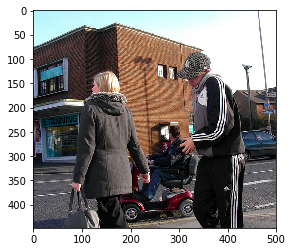

Generated caption: Two men riding in a bike , on the street .


In [68]:
from scipy.misc import imread
import random

r = random.randint(0, len(test_img)-1)

try_image = test_img[r]
print(try_image)
%matplotlib inline
plt.imshow(imread(try_image))
plt.show()
plt.clf()
print ('Generated caption:', predict_captions(try_image))